## == EDA  ==

In [134]:
import gzip
import json
import pandas as  pd
import matplotlib.pyplot as plt

plt.style.use = 'ggplot'

### == Overview == 


Below is a single purchase and all of it's associated data. Some things like bonus points earned or purchase date lend themselves to structured data pretty well. These will fit into a SQL database with no problem. But the actual items are much more varied and larger purchases make larger units of data. This is rich data and things like product partner ID can be used to link purchases to brands in other data sources.

For simplicity sake and building rudimentary structured data for quality analysis I have largely removed this qualitative data.

In [136]:
# Pull a single row

url_receipts = 'data/receipts.json.gz'

with gzip.open(url_receipts, 'r') as file:
    bytes_data = file.read()
    data_str = bytes_data.decode('utf-8')

# Separate different rows of data, list of strings
data = data_str.split('\n')

# One select row
json.loads(data[12])

{'_id': {'$oid': '5ff1e1b60a7214ada100055c'},
 'bonusPointsEarned': 150,
 'bonusPointsEarnedReason': 'Receipt number 5 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)',
 'createDate': {'$date': 1609687478000},
 'dateScanned': {'$date': 1609687478000},
 'modifyDate': {'$date': 1609687478000},
 'pointsEarned': '8850.0',
 'purchaseDate': {'$date': 1612365878000},
 'purchasedItemCount': 10,
 'rewardsReceiptItemList': [{'barcode': '034100573065',
   'description': 'MILLER LITE 24 PACK 12OZ CAN',
   'finalPrice': '29',
   'itemPrice': '29',
   'partnerItemId': '1',
   'pointsEarned': '870.0',
   'pointsPayerId': '5332f709e4b03c9a25efd0f1',
   'quantityPurchased': 1,
   'rewardsGroup': 'MILLER LITE 24 PACK',
   'rewardsProductPartnerId': '5332f709e4b03c9a25efd0f1',
   'targetPrice': '77'},
  {'barcode': '034100573065',
   'description': 'MILLER LITE 24 PACK 12OZ CAN',
   'finalPrice': '29',
   'itemPrice': '29',
   'partnerItemId': '2',
   'pointsEarned': '870.0',
   'point

In [52]:
'''
Below is a modified version of the populate_sql function found in
fetch.py. This one is used to populate a pandas dataframe instead
of a SQL database.
'''

def populate_pd(url):
    '''Transforms .json.gz zip file data into a pandas df'''
    
    # First unzip raw data
    with gzip.open(url, 'r') as file:
        bytes_data = file.read()
        data_str = bytes_data.decode('utf-8')

    # Separate different rows of data, list of strings
    data = data_str.split('\n')
    
    # First row of data to seed the dataframe
    df = pd.Series(flatten_json(json.loads(data[0])))

    # Loops through each "row" and adds it as a new df column
    for i in range(1, len(data)-1):
        # Get data from row
        row = pd.Series(flatten_json(json.loads(data[i])))
        
        df = pd.concat([df, row], axis=1)
        
        # Remove listed purchase items in receipts data specifically
        # Although this is rich data, it is very messy
        df = df[~df.index.str.contains("List")]
    
    # Reorient dataframe so rows are data and columns are features
    df = df.T.reset_index(drop=True)
    
    # Data comes from JSON objects which do dates as unix time in milliseconds
    date_cols = ['createdDate_$date', 'lastLogin_$date', 'createDate_$date',
                 'dateScanned_$date', 'finishedDate_$date', 'modifyDate_$date',
                 'pointsAwardedDate_$date', 'pointsEarned', 'purchaseDate_$date']
    
    for col in date_cols:
        if col in df.columns:
            print(col)
            df[col] = pd.to_datetime(df[col], unit='ms')
    
    return df

# Useful recursive function to flatten any given JSON row
# Copied from https://www.geeksforgeeks.org/flattening-json-objects-in-python/

def flatten_json(y):
    out = {}
  
    def flatten(x, name =''):
          
        # If the Nested key-value 
        # pair is of dict type
        if type(x) is dict:
              
            for a in x:
                flatten(x[a], name + a + '_')
                  
        # If the Nested key-value
        # pair is of list type
        elif type(x) is list:
              
            i = 0
              
            for a in x:                
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x
  
    flatten(y)
    return out

In [53]:
df_users = populate_pd('data/users.json.gz')
df_users

createdDate_$date
lastLogin_$date


,_id_$oid,active,createdDate_$date,lastLogin_$date,role,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
1,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
2,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
3,5ff1e1eacfcf6c399c274ae6,True,2021-01-03 15:25:30.554,2021-01-03 15:25:30.597,consumer,Email,WI
4,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
...,...,...,...,...,...,...,...
490,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204,fetch-staff,NaN,NaN
491,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204,fetch-staff,NaN,NaN
492,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204,fetch-staff,NaN,NaN
493,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204,fetch-staff,NaN,NaN


In [54]:
df_brands = populate_pd('data/brands.json.gz')
df_brands

,_id_$oid,barcode,category,categoryCode,cpg_$id_$oid,cpg_$ref,name,topBrand,brandCode
0,601ac115be37ce2ead437551,511111019862,Baking,BAKING,601ac114be37ce2ead437550,Cogs,test brand @1612366101024,False,NaN
1,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,5332f5fbe4b03c9a25efd0ba,Cogs,Starbucks,False,STARBUCKS
2,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,601ac142be37ce2ead437559,Cogs,test brand @1612366146176,False,TEST BRANDCODE @1612366146176
3,601ac142be37ce2ead43755a,511111519874,Baking,BAKING,601ac142be37ce2ead437559,Cogs,test brand @1612366146051,False,TEST BRANDCODE @1612366146051
4,601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,5332fa12e4b03c9a25efd1e7,Cogs,test brand @1612366146827,False,TEST BRANDCODE @1612366146827
...,...,...,...,...,...,...,...,...,...
1162,5f77274dbe37ce6b592e90c0,511111116752,Baking,BAKING,5f77274dbe37ce6b592e90bf,Cogs,test brand @1601644365844,NaN,NaN
1163,5dc1fca91dda2c0ad7da64ae,511111706328,Breakfast & Cereal,NaN,53e10d6368abd3c7065097cc,Cogs,Dippin Dots® Cereal,NaN,DIPPIN DOTS CEREAL
1164,5f494c6e04db711dd8fe87e7,511111416173,Candy & Sweets,CANDY_AND_SWEETS,5332fa12e4b03c9a25efd1e7,Cogs,test brand @1598639215217,NaN,TEST BRANDCODE @1598639215217
1165,5a021611e4b00efe02b02a57,511111400608,Grocery,NaN,5332f5f6e4b03c9a25efd0b4,Cogs,LIPTON TEA Leaves,False,LIPTON TEA Leaves


In [55]:
df_receipts = populate_pd('data/receipts.json.gz')
df_receipts

createDate_$date
dateScanned_$date
finishedDate_$date
modifyDate_$date
pointsAwardedDate_$date
pointsEarned
purchaseDate_$date


,_id_$oid,bonusPointsEarned,bonusPointsEarnedReason,createDate_$date,dateScanned_$date,finishedDate_$date,modifyDate_$date,pointsAwardedDate_$date,pointsEarned,purchaseDate_$date,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId
0,5ff1e1eb0a720f0523000575,500,"Receipt number 2 completed, bonus point schedu...",2021-01-03 15:25:31.000,2021-01-03 15:25:31.000,2021-01-03 15:25:31,2021-01-03 15:25:36.000,2021-01-03 15:25:31,1970-01-01 00:00:00.500,2021-01-03 00:00:00,5,FINISHED,26.00,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,150,"Receipt number 5 completed, bonus point schedu...",2021-01-03 15:24:43.000,2021-01-03 15:24:43.000,2021-01-03 15:24:43,2021-01-03 15:24:48.000,2021-01-03 15:24:43,1970-01-01 00:00:00.150,2021-01-02 15:24:43,2,FINISHED,11.00,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,5,All-receipts receipt bonus,2021-01-03 15:25:37.000,2021-01-03 15:25:37.000,NaT,2021-01-03 15:25:42.000,NaT,1970-01-01 00:00:00.005,2021-01-03 00:00:00,1,REJECTED,10.00,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,5,All-receipts receipt bonus,2021-01-03 15:25:34.000,2021-01-03 15:25:34.000,2021-01-03 15:25:34,2021-01-03 15:25:39.000,2021-01-03 15:25:34,1970-01-01 00:00:00.005,2021-01-03 00:00:00,4,FINISHED,28.00,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,5,All-receipts receipt bonus,2021-01-03 15:25:06.000,2021-01-03 15:25:06.000,2021-01-03 15:25:11,2021-01-03 15:25:11.000,2021-01-03 15:25:06,1970-01-01 00:00:00.005,2021-01-02 15:25:06,2,FINISHED,1.00,5ff1e194b6a9d73a3a9f1052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,603cc0630a720fde100003e6,25,COMPLETE_NONPARTNER_RECEIPT,2021-03-01 10:22:27.000,2021-03-01 10:22:27.000,NaT,2021-03-01 10:22:28.000,NaT,1970-01-01 00:00:00.025,2020-08-17 00:00:00,2,REJECTED,34.96,5fc961c3b8cfca11a077dd33
1115,603d0b710a720fde1000042a,NaN,NaN,2021-03-01 15:42:41.873,2021-03-01 15:42:41.873,NaT,2021-03-01 15:42:41.873,NaT,NaT,NaT,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33
1116,603cf5290a720fde10000413,NaN,NaN,2021-03-01 14:07:37.664,2021-03-01 14:07:37.664,NaT,2021-03-01 14:07:37.664,NaT,NaT,NaT,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33
1117,603ce7100a7217c72c000405,25,COMPLETE_NONPARTNER_RECEIPT,2021-03-01 13:07:28.000,2021-03-01 13:07:28.000,NaT,2021-03-01 13:07:29.000,NaT,1970-01-01 00:00:00.025,2020-08-17 00:00:00,2,REJECTED,34.96,5fc961c3b8cfca11a077dd33


### == Missing data ==

Let's see what features have missing data for each data set.

In [25]:
# Missing data in users, out of 495 users

df_users.isna().sum()

_id_$oid              0
active                0
createdDate_$date     0
lastLogin_$date      62
role                  0
signUpSource         48
state                56
dtype: int64

In [26]:
# Missing data in brands, out of 1167 brands

df_brands.isna().sum()

_id_$oid          0
barcode           0
category        155
categoryCode    650
cpg_$id_$oid      0
cpg_$ref          0
name              0
topBrand        612
brandCode       234
dtype: int64

In [27]:
# Missing data in receipts, out of 1119 receipts

df_receipts.isna().sum()

_id_$oid                     0
bonusPointsEarned          575
bonusPointsEarnedReason    575
createDate_$date             0
dateScanned_$date            0
finishedDate_$date         551
modifyDate_$date             0
pointsAwardedDate_$date    582
pointsEarned               510
purchaseDate_$date         448
purchasedItemCount         484
rewardsReceiptStatus         0
totalSpent                 435
userId                       0
dtype: int64

When a receipt has no information in bonus points earned, that looks like it may functionally be 0 points rather than some sort of error.

Indeed when we pick rows that have no bonus points information most other rows are still filled out.

In [107]:
df_receipts[~df_receipts['bonusPointsEarned'].isna()].isna().sum()

_id_$oid                    0
bonusPointsEarned           0
bonusPointsEarnedReason     0
createDate_$date            0
dateScanned_$date           0
finishedDate_$date         88
modifyDate_$date            0
pointsAwardedDate_$date    65
pointsEarned                0
purchaseDate_$date          0
purchasedItemCount          0
rewardsReceiptStatus        0
totalSpent                  0
userId                      0
dtype: int64

### == Misc analysis ==

There are 31 "top brands." Let's see what they are out of curiousity.

Some brands I am not familiar with surprisingly.

In [58]:
df_brands['topBrand'].value_counts()

False    524
True      31
Name: topBrand, dtype: int64

In [129]:
df_brands[df_brands['topBrand'] == True].brandCode

58          TEST BRAND CODE
109               CHESTER'S
115                 DORITOS
116                    A.1.
152              0987654321
192                 CHEETOS
245                     NaN
258                    AMP2
271            CAP'N CRUNCH
278                        
344               FRITO-LAY
428                 AMPTEST
467                   ALEXA
471               GRANDMA'S
580     DASH-2249 1 BRAND 1
581            CRACKER JACK
721                  FRITOS
723              BRAND CODE
773                        
848               BAKEN-ETS
943               ALEXA-O'S
978                 PULLUPS
1012            09090909090
1018                  LAY'S
1020          BEN & JERRY'S
1023                 FRS920
1030                BREYERS
1036              GOODNITES
1061              EL ISLENO
1074                HUGGIES
1109                FUNYUNS
Name: brandCode, dtype: object

Let's see the distribution of bonus points people are earning.

It seems as if there's a point cap around 700 and most purchases end up being 0 points.

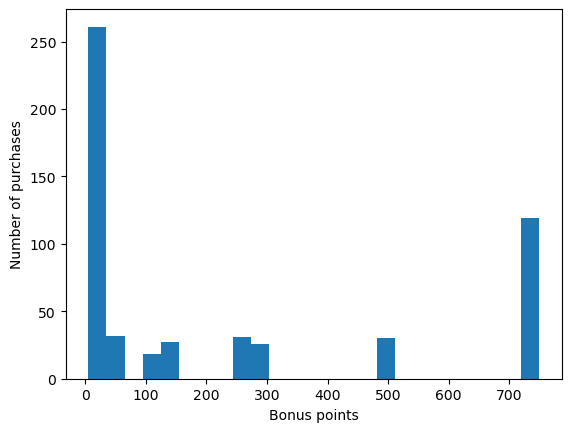

In [130]:
x = df_receipts[~df_receipts['bonusPointsEarned'].isna()].bonusPointsEarned

fig, ax = plt.subplots()

ax.hist(x, bins=25)
ax.set_xlabel('Bonus points')
ax.set_ylabel('Number of purchases')

plt.show()

How many things are people buying?

Even amount around 1000 purchases there's still a handful that are over 100 items! As many as 689. Do these warrant further investigation? Maybe, but maybe not if there is a point cap and these are truly edge cases.

In [133]:
df_receipts[df_receipts['purchasedItemCount'] > 100]

,_id_$oid,bonusPointsEarned,bonusPointsEarnedReason,createDate_$date,dateScanned_$date,finishedDate_$date,modifyDate_$date,pointsAwardedDate_$date,pointsEarned,purchaseDate_$date,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId
303,600208270a720f05f3000088,500,"Receipt number 2 completed, bonus point schedu...",2021-01-15 21:24:55,2021-01-15 21:24:55,2021-01-15 21:26:19,2021-01-15 21:26:29,2021-01-15 21:26:19,1970-01-01 00:00:00.605700,2021-01-09,103,FINISHED,427.81,6000b75bbe5fc96dfee1d4d3
305,600373700a720f05f3000091,750,"Receipt number 1 completed, bonus point schedu...",2021-01-16 23:14:56,2021-01-16 23:14:56,2021-01-16 23:29:50,2021-01-16 23:31:40,2021-01-16 23:29:50,1970-01-01 00:00:02.416700,2021-01-16,211,FINISHED,803.48,60037329e257124ec6b99eeb
306,60023e8f0a720f05f300008b,750,"Receipt number 1 completed, bonus point schedu...",2021-01-16 01:17:03,2021-01-16 01:17:03,2021-01-16 01:24:04,2021-01-16 01:24:50,2021-01-16 01:24:04,1970-01-01 00:00:01.806400,2021-01-05,202,FINISHED,776.79,60023de5fb296c121a81b955
310,6002590c0a7214ad4c000082,750,"Receipt number 1 completed, bonus point schedu...",2021-01-16 03:10:04,2021-01-16 03:10:04,2021-01-16 03:18:55,2021-01-16 03:19:12,2021-01-16 03:18:55,1970-01-01 00:00:01.516900,2021-01-14,208,FINISHED,746.94,600258dafb296c4ef805d9b7
314,60025cb80a720f05f300008d,750,"Receipt number 1 completed, bonus point schedu...",2021-01-16 03:25:44,2021-01-16 03:25:44,2021-01-16 03:31:55,2021-01-16 03:32:05,2021-01-16 03:31:55,1970-01-01 00:00:01.658300,2021-01-15,335,FINISHED,1177.84,60025c65fb296c4ef805d9e6
315,600370250a720f05f3000090,750,"Receipt number 1 completed, bonus point schedu...",2021-01-16 23:00:53,2021-01-16 23:00:53,2021-01-16 23:09:03,2021-01-16 23:09:29,2021-01-16 23:09:03,1970-01-01 00:00:02.685800,2021-01-16,240,FINISHED,850.49,60037005e257124ec6b99ec2
318,600260210a720f05f300008f,750,"Receipt number 1 completed, bonus point schedu...",2021-01-16 03:40:17,2021-01-16 03:40:17,2021-01-16 03:47:26,2021-01-16 03:47:31,2021-01-16 03:47:26,1970-01-01 00:00:03.659400,2021-01-15,309,FINISHED,1043.18,60025fe0e257124ec6b99a87
321,6004a5f20a7214ad4c000088,750,"Receipt number 1 completed, bonus point schedu...",2021-01-17 21:02:42,2021-01-17 21:02:42,2021-01-17 21:09:44,2021-01-17 21:14:15,2021-01-17 21:09:44,1970-01-01 00:00:00.877700,2021-01-09,164,FINISHED,574.16,6004a5d3fb296c4ef805e256
324,60049d9d0a720f05f3000094,750,"Receipt number 1 completed, bonus point schedu...",2021-01-17 20:27:09,2021-01-17 20:27:09,2021-01-17 20:40:36,2021-01-17 20:41:17,2021-01-17 20:40:36,1970-01-01 00:00:00.922100,2021-01-01,212,FINISHED,743.79,60049cdce257124ec6b9a353
327,6004a99e0a720f05f3000095,750,"Receipt number 1 completed, bonus point schedu...",2021-01-17 21:18:21,2021-01-17 21:18:21,2021-01-17 21:26:38,2021-01-18 15:01:00,2021-01-17 21:26:38,1970-01-01 00:00:01.541800,2021-01-09,167,FINISHED,574.65,6004a965e257124ec6b9a39f


A quick analysis of a handful of easy to check metrics hasn't yielded any data quality issues outside of the one mentioned at the top.